In [1]:
import os 
import random
import numpy as np

import torch 
from torch import nn 
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import random
import copy
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
import cv2
import json

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
model_ident = "bidiretional_lstm_hrnet_nturgb"
unique_iden = "epoch10_emb1024_xy"

main_dir = "D:\\FYP\\HAR-ZSL-XAI"
data_dir = os.path.join(main_dir,"data","sequence_data","random_50f")
epoch_vids = os.path.join(main_dir,"epoch_vids")
models_saves = os.path.join(main_dir,"model_saves")
embeddings_save = os.path.join(main_dir,"embedding_save")
test_vids = os.path.join(main_dir,"test_vids")
class_names = os.listdir(data_dir)
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 1-train_ratio - val_ratio
batch_size = 256

os.makedirs(epoch_vids,exist_ok=True)
os.makedirs(models_saves,exist_ok=True)
os.makedirs(embeddings_save,exist_ok=True)

In [4]:
config = {
    "n_epochs":50,
    "model_name":"BidirectionalLSTM",
    "model":{
        "seq_len":50,
        "input_size":12*2,
        "hidden_size":1024,
        "linear_filters":[128,256,512,1024],
        "embedding_size":1024,
        "num_layers":1,
        "bidirectional":True,
        "batch_size":batch_size,
        "dev":device
    }
}

In [5]:
def classname_id(class_name_list):
    id2classname = {k:v for k, v in zip(list(range(len(class_name_list))),class_name_list)}
    classname2id = {v:k for k, v in id2classname.items()}
    return id2classname, classname2id

In [6]:
 class_names = [str(x) for x in range(120)]

In [7]:
id2clsname, clsname2id = classname_id(class_names)

In [8]:
train_file_list = []
val_file_list = []
test_file_list = []

file_list = [os.path.join(data_dir,x) for x in os.listdir(data_dir)]

random.shuffle(file_list)
num_list = len(file_list)

train_range = [0,int(num_list*train_ratio)]
val_range = [int(num_list*train_ratio),int(num_list*(train_ratio+val_ratio))]
test_range = [int(num_list*(train_ratio+val_ratio)),num_list-1]

train_file_list += file_list[train_range[0]:train_range[1]]
val_file_list += file_list[val_range[0]:val_range[1]]
test_file_list += file_list[test_range[0]:test_range[1]]

In [9]:
len(train_file_list),len(val_file_list),len(test_file_list)

(18012, 2252, 2251)

In [10]:
train_file_list = train_file_list[:(len(train_file_list)//batch_size)*batch_size]
val_file_list = val_file_list[:(len(val_file_list)//batch_size)*batch_size]
test_file_list = test_file_list[:(len(test_file_list)//batch_size)*batch_size]

In [11]:
len(train_file_list),len(val_file_list),len(test_file_list)

(17920, 2048, 2048)

In [12]:
class SkeletonDataset(Dataset):
    def __init__(self, file_list,class2id, transform=None, 
                 target_transform=None,active_locations=[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],file_name=False, is_2d=False):
        self.file_list = file_list
        self.transform = transform
        self.class2id = class2id
        self.target_transform = target_transform
        self.active_locations = active_locations
        self.file_name = file_name
        self.is_2d = is_2d

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        a_file = np.load(self.file_list[idx])
        action_type = self.file_list[idx].strip().split(os.path.sep)[-1].split("_cls_")[0]
        coords, vid_size = a_file["coords"],a_file["video_size"]
        coords = coords[:,self.active_locations,:]

        if self.is_2d:
            coords = coords[...,0:2]

        shape = coords.shape

        coords = torch.from_numpy(coords).float()

        coords = torch.reshape(coords, (shape[0], shape[1]*shape[2]))
        label = torch.clone(coords)

        if self.transform:
            coords = self.transform(coords)
        if self.target_transform:
            label = self.target_transform(coords)

        if self.file_name:
            return coords, label, self.class2id[action_type],a_file["video_size"],self.file_list[idx]
        return coords, label, self.class2id[action_type],a_file["video_size"]

In [13]:
train_data = SkeletonDataset(train_file_list,clsname2id,is_2d=True)
val_data = SkeletonDataset(val_file_list,clsname2id,is_2d=True)
test_data = SkeletonDataset(test_file_list,clsname2id,is_2d=True)

In [14]:
train_dl = DataLoader(train_data, batch_size=batch_size, shuffle=False)
val_dl = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_dl = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [15]:
for x in train_dl:
    print(x[0].shape)
    break

torch.Size([256, 50, 24])


In [16]:

class BiLSTMEncoder(nn.Module):
    def __init__(self,seq_len, input_size, hidden_size,linear_filters,embedding_size:int, num_layers = 1,bidirectional=True,dev=device):
        super(BiLSTMEncoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dev=dev
        self.num_layers = num_layers
        self.linear_filters = linear_filters
        self.embedding_size = embedding_size
        self.bidirectional = bidirectional
        self.seq_len = seq_len

        # define LSTM layer
        self.layers = []

        # add linear layers 
        for __id,layer_out in enumerate(self.linear_filters):
            if __id == 0:
                self.layers.append(nn.Linear(self.input_size, layer_out))
            else:
                self.layers.append(nn.Linear(self.linear_filters[__id-1], layer_out))

        # add lstm layer
        self.lstm = nn.LSTM(input_size = layer_out, hidden_size = self.hidden_size,
                            num_layers = self.num_layers, bidirectional=self.bidirectional,
                            batch_first=True)
        
        self.net = nn.Sequential(*self.layers)

        #add embedding out
        if bidirectional:
            self.out_linear = nn.Linear(self.hidden_size*4, self.embedding_size)
        else:
            self.out_linear = nn.Linear(self.hidden_size*2, self.embedding_size)

        
    def forward(self, x_input):
        """
        : param x_input:               input of shape (seq_len, # in batch, input_size)
        : return lstm_out, hidden:     lstm_out gives all the hidden states in the sequence; hidden gives the hidden state and cell state for the last element in the sequence
        """
        
        x = self.net(x_input)
        lstm_out, self.hidden = self.lstm(x)
        hidden_transformed = torch.cat(self.hidden,0)
        hidden_transformed = torch.transpose(hidden_transformed,0,1)
        hidden_transformed = torch.flatten(hidden_transformed,start_dim=1)
        
        hidden_transformed = self.out_linear(hidden_transformed)
        
        return lstm_out, hidden_transformed

    
class BiLSTMDecoder(nn.Module):
    def __init__(self,seq_len, input_size, hidden_size, linear_filters,embedding_size:int, num_layers = 1,bidirectional=True,dev=device):
        super(BiLSTMDecoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dev = dev
        self.num_layers = num_layers
        self.linear_filters = linear_filters[::-1]
        self.embedding_size = embedding_size
        self.bidirectional = bidirectional
        self.seq_len = seq_len

        if bidirectional:
            self.input_linear = nn.Linear(self.embedding_size,4*self.hidden_size)
        else:
            self.input_linear = nn.Linear(self.embedding_size,2*self.hidden_size)

        # define LSTM layer
        self.layers = []
        # add lstm
        self.lstm = nn.LSTM(input_size = self.linear_filters[0], hidden_size = self.hidden_size,
                            num_layers = self.num_layers, bidirectional=True,
                            batch_first=bidirectional)

                        
        # add linear layers 
        if bidirectional:
            self.layers.append(nn.Linear(2*hidden_size,self.linear_filters[0]))
        else:
            self.layers.append(nn.Linear(hidden_size,self.linear_filters[0]))

        for __id,layer_in in enumerate(self.linear_filters):
            if __id == len(linear_filters)-1:
                self.layers.append(nn.Linear(layer_in,self.input_size))
            else:
                self.layers.append(nn.Linear(layer_in,self.linear_filters[__id+1]))

        self.net = nn.Sequential(*self.layers)

        
        

    def forward(self,encoder_hidden):
        """
        : param x_input:               input of shape (seq_len, # in batch, input_size)
        : return lstm_out, hidden:     lstm_out gives all the hidden states in the sequence; hidden gives the hidden state and cell state for the last element in the sequence
        """
        
        
        hidden_shape = encoder_hidden.shape
        encoder_hidden = self.input_linear(encoder_hidden)
        
        if self.bidirectional:
            hidden = encoder_hidden.view((-1,4,self.hidden_size))
            hidden = torch.transpose(hidden,1,0)
            h1,h2,c1,c2 = torch.unbind(hidden,0)
            h,c = torch.stack((h1,h2)),torch.stack((c1,c2))
            bs = h.size()[1]
        else:
            hidden = encoder_hidden.view((-1,2,self.hidden_size))
            hidden = torch.transpose(hidden,1,0)
            h,c = torch.unbind(hidden,0)
            bs = h.size()[1]
        
        dummy_input = torch.rand((bs,self.seq_len,self.hidden_size), requires_grad=True).to(self.dev)
        
        lstm_out, self.hidden = self.lstm(dummy_input,(h,c))
        x = self.net(lstm_out)
        
        return x

class BiLSTMEncDecModel(nn.Module):
    def __init__(self,seq_len, input_size, hidden_size, linear_filters=[128,256,512],embedding_size:int=256, num_layers = 1,bidirectional=True,dev=device):
        super(BiLSTMEncDecModel, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dev = dev
        self.num_layers = num_layers
        self.linear_filters = linear_filters[::-1]
        self.embedding_size = embedding_size
        self.bidirectional = bidirectional
        self.batch_size = batch_size
        self.seq_len = seq_len
        
        self.encoder = BiLSTMEncoder(seq_len, input_size, hidden_size, linear_filters,embedding_size, num_layers = 1,bidirectional=True, dev=self.dev)
        self.decoder = BiLSTMDecoder(seq_len, input_size, hidden_size, linear_filters,embedding_size, num_layers = 1,bidirectional=True, dev=self.dev)
        
    def forward(self,x):
        lstm_out,embedding = self.encoder(x)
        decoder_out = self.decoder(embedding)
        
        return decoder_out, embedding  
        

In [17]:
encoder = BiLSTMEncoder(
    seq_len=config["model"]["seq_len"],
    input_size=config["model"]["input_size"],
    hidden_size=config["model"]["hidden_size"],
    linear_filters=config["model"]["linear_filters"],
    embedding_size=config["model"]["embedding_size"],
    num_layers = config["model"]["num_layers"],
    bidirectional=config["model"]["bidirectional"],
    dev=config["model"]["dev"]).to(device)

decoder = BiLSTMDecoder(
    seq_len=config["model"]["seq_len"],
    input_size=config["model"]["input_size"],
    hidden_size=config["model"]["hidden_size"],
    linear_filters=config["model"]["linear_filters"],
    embedding_size=config["model"]["embedding_size"],
    num_layers = config["model"]["num_layers"],
    bidirectional=config["model"]["bidirectional"],
    dev=config["model"]["dev"]).to(device)

bilstm_model = BiLSTMEncDecModel(
    seq_len=config["model"]["seq_len"],
    input_size=config["model"]["input_size"],
    hidden_size=config["model"]["hidden_size"],
    linear_filters=config["model"]["linear_filters"],
    embedding_size=config["model"]["embedding_size"],
    num_layers = config["model"]["num_layers"],
    bidirectional=config["model"]["bidirectional"],
    dev=config["model"]["dev"])

In [18]:
bilstm_model.to(device)

BiLSTMEncDecModel(
  (encoder): BiLSTMEncoder(
    (lstm): LSTM(1024, 1024, batch_first=True, bidirectional=True)
    (net): Sequential(
      (0): Linear(in_features=24, out_features=128, bias=True)
      (1): Linear(in_features=128, out_features=256, bias=True)
      (2): Linear(in_features=256, out_features=512, bias=True)
      (3): Linear(in_features=512, out_features=1024, bias=True)
    )
    (out_linear): Linear(in_features=4096, out_features=1024, bias=True)
  )
  (decoder): BiLSTMDecoder(
    (input_linear): Linear(in_features=1024, out_features=4096, bias=True)
    (lstm): LSTM(1024, 1024, batch_first=True, bidirectional=True)
    (net): Sequential(
      (0): Linear(in_features=2048, out_features=1024, bias=True)
      (1): Linear(in_features=1024, out_features=512, bias=True)
      (2): Linear(in_features=512, out_features=256, bias=True)
      (3): Linear(in_features=256, out_features=128, bias=True)
      (4): Linear(in_features=128, out_features=24, bias=True)
    )
  )

In [19]:
lstm_out, embedding = encoder(torch.randn((32,50,24)).to(device))

In [20]:

embedding.shape

torch.Size([32, 1024])

In [21]:
decoder_out = decoder(embedding)

In [22]:
model_out,embedding = bilstm_model(torch.randn((32,50,24)).to(device))

In [23]:
model_out.shape

torch.Size([32, 50, 24])

In [24]:
model_out,embedding = bilstm_model(torch.randn((16,50,24)).to(device))

In [25]:
model_out.shape

torch.Size([16, 50, 24])

In [26]:
model_out,embedding = bilstm_model(torch.randn((5,50,24)).to(device))

In [27]:
model_out.shape

torch.Size([5, 50, 24])

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mapping_l = [
        [15, 13], [13, 11], [11, 5],
        [12, 14], [14, 16], [12, 6],
        [3, 1],[1, 2],[1, 0],[0, 2],[2,4],
        [9, 7], [7,5], [5, 6],
        [6, 8], [8, 10],
        ]
#mapping_l = []

from dataset.SkeletonData.visualize import *
from utils.train_utils import *

In [29]:
def train_model(model, train_dataset, val_dataset, n_epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    std_loss = nn.L1Loss(reduction='mean').to(device)
    history = dict(train=[], val=[])
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10000.0
  
    for epoch in range(1, n_epochs + 1):
        model = model.train()

        train_losses = []
        for in_seq,tar_seq,action,vid_size in tqdm(train_dataset):
            optimizer.zero_grad()
            
            in_seq = in_seq.to(device)
            tar_seq = tar_seq.to(device)
            seq_pred,_  = model(in_seq)
            
            loss = std_loss(seq_pred, tar_seq)
            #loss += 0.5*contrastive_loss(embed,labels=sample_label.view(-1))
            #print(contrastive_loss(embed,labels=sample_label.view(-1)))

            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

        val_losses = []
        model = model.eval()
        with torch.no_grad():
            for in_seq,tar_seq,action,vid_size in val_dataset:

                in_seq = in_seq.to(device)
                tar_seq = tar_seq.to(device)
                seq_pred,_  = model(in_seq)

                loss = std_loss(seq_pred, tar_seq)
                #loss += 0.5*contrastive_loss(embed,labels=sample_label.view(-1))
                val_losses.append(loss.item())

        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)

        history['train'].append(train_loss)
        history['val'].append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

        print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

    model.load_state_dict(best_model_wts)
    save_model(model,model_ident,unique_iden,models_saves,config)
    return model.eval(), history

In [30]:
model, history = train_model(
  bilstm_model, 
  train_dl, 
  val_dl, 
  n_epochs=config["n_epochs"]
)

100%|██████████| 70/70 [02:21<00:00,  2.02s/it]


Epoch 1: train loss 0.10918182629559721 val loss 0.06028963439166546


100%|██████████| 70/70 [02:18<00:00,  1.98s/it]


Epoch 2: train loss 0.06344282254576683 val loss 0.07663351204246283


100%|██████████| 70/70 [03:01<00:00,  2.59s/it]


Epoch 3: train loss 0.06023090433861528 val loss 0.05596730066463351


100%|██████████| 70/70 [04:06<00:00,  3.52s/it]


Epoch 4: train loss 0.0457230809543814 val loss 0.0422576772980392


100%|██████████| 70/70 [05:14<00:00,  4.49s/it]


Epoch 5: train loss 0.04626484486673559 val loss 0.050955531653016806


100%|██████████| 70/70 [03:16<00:00,  2.81s/it]


Epoch 6: train loss 0.03760120727654014 val loss 0.030682769836857915


100%|██████████| 70/70 [03:41<00:00,  3.17s/it]


Epoch 7: train loss 0.03436664039535182 val loss 0.03245456703007221


100%|██████████| 70/70 [03:50<00:00,  3.30s/it]


Epoch 8: train loss 0.03027528678732259 val loss 0.03142104437574744


100%|██████████| 70/70 [03:52<00:00,  3.32s/it]


Epoch 9: train loss 0.02957438145365034 val loss 0.031553588807582855


100%|██████████| 70/70 [03:49<00:00,  3.28s/it]


Epoch 10: train loss 0.029397427636597837 val loss 0.03042943892069161


100%|██████████| 70/70 [03:44<00:00,  3.21s/it]


Epoch 11: train loss 0.030865106571997914 val loss 0.02957075834274292


100%|██████████| 70/70 [03:45<00:00,  3.22s/it]


Epoch 12: train loss 0.028584496304392814 val loss 0.028103218413889408


100%|██████████| 70/70 [03:46<00:00,  3.23s/it]


Epoch 13: train loss 0.028381386931453433 val loss 0.025366134708747268


100%|██████████| 70/70 [03:45<00:00,  3.23s/it]


Epoch 14: train loss 0.026581364311277868 val loss 0.025303774513304234


100%|██████████| 70/70 [03:45<00:00,  3.22s/it]


Epoch 15: train loss 0.025114307925105096 val loss 0.02357055922038853


100%|██████████| 70/70 [04:15<00:00,  3.65s/it]


Epoch 16: train loss 0.024384988604911735 val loss 0.025623231660574675


100%|██████████| 70/70 [04:19<00:00,  3.71s/it]


Epoch 17: train loss 0.023554311745933126 val loss 0.025904255686327815


100%|██████████| 70/70 [04:21<00:00,  3.73s/it]


Epoch 18: train loss 0.023592569971723217 val loss 0.02455824497155845


100%|██████████| 70/70 [04:00<00:00,  3.43s/it]


Epoch 19: train loss 0.023603746294975282 val loss 0.023570001125335693


100%|██████████| 70/70 [03:45<00:00,  3.22s/it]


Epoch 20: train loss 0.02282833967890058 val loss 0.02290190360508859


100%|██████████| 70/70 [03:45<00:00,  3.22s/it]


Epoch 21: train loss 0.023136915399559907 val loss 0.023035437567159534


100%|██████████| 70/70 [03:36<00:00,  3.09s/it]


Epoch 22: train loss 0.022389037774077483 val loss 0.021480975905433297


100%|██████████| 70/70 [03:32<00:00,  3.04s/it]


Epoch 23: train loss 0.022028631397656033 val loss 0.021086987806484103


100%|██████████| 70/70 [03:26<00:00,  2.94s/it]


Epoch 24: train loss 0.022239186002739837 val loss 0.021625383524224162


100%|██████████| 70/70 [03:27<00:00,  2.97s/it]


Epoch 25: train loss 0.02131464813968965 val loss 0.02189278742298484


100%|██████████| 70/70 [03:26<00:00,  2.96s/it]


Epoch 26: train loss 0.021149196954710143 val loss 0.022380950395017862


100%|██████████| 70/70 [03:29<00:00,  2.99s/it]


Epoch 27: train loss 0.021029515830533845 val loss 0.02282087574712932


100%|██████████| 70/70 [03:25<00:00,  2.94s/it]


Epoch 28: train loss 0.020694858474390846 val loss 0.02145526697859168


100%|██████████| 70/70 [03:20<00:00,  2.87s/it]


Epoch 29: train loss 0.02014427695955549 val loss 0.020046432968229055


100%|██████████| 70/70 [03:18<00:00,  2.84s/it]


Epoch 30: train loss 0.020366727081792695 val loss 0.02004406019113958


100%|██████████| 70/70 [03:14<00:00,  2.78s/it]


Epoch 31: train loss 0.02016280623418944 val loss 0.01926739583723247


100%|██████████| 70/70 [03:16<00:00,  2.81s/it]


Epoch 32: train loss 0.02027757218373673 val loss 0.020693440921604633


100%|██████████| 70/70 [03:23<00:00,  2.91s/it]


Epoch 33: train loss 0.019282684288918973 val loss 0.019344624830409884


100%|██████████| 70/70 [03:24<00:00,  2.92s/it]


Epoch 34: train loss 0.019163727813533375 val loss 0.019364717649295926


100%|██████████| 70/70 [03:17<00:00,  2.82s/it]


Epoch 35: train loss 0.018491949726428304 val loss 0.018126917770132422


100%|██████████| 70/70 [03:16<00:00,  2.81s/it]


Epoch 36: train loss 0.018499126764280456 val loss 0.020528536289930344


100%|██████████| 70/70 [03:19<00:00,  2.84s/it]


Epoch 37: train loss 0.018979455956390928 val loss 0.018622429110109806


100%|██████████| 70/70 [03:16<00:00,  2.81s/it]


Epoch 38: train loss 0.018377316024686608 val loss 0.017341310158371925


100%|██████████| 70/70 [03:18<00:00,  2.83s/it]


Epoch 39: train loss 0.017922715935856103 val loss 0.0176870736759156


100%|██████████| 70/70 [03:16<00:00,  2.81s/it]


Epoch 40: train loss 0.017651482857763766 val loss 0.0170023322571069


100%|██████████| 70/70 [03:12<00:00,  2.75s/it]


Epoch 41: train loss 0.017183017717408284 val loss 0.017241681925952435


100%|██████████| 70/70 [03:08<00:00,  2.69s/it]


Epoch 42: train loss 0.016907376077558312 val loss 0.015876844990998507


100%|██████████| 70/70 [03:10<00:00,  2.73s/it]


Epoch 43: train loss 0.016708123244877374 val loss 0.016903828363865614


100%|██████████| 70/70 [03:20<00:00,  2.87s/it]


Epoch 44: train loss 0.016480200232139655 val loss 0.017355741234496236


100%|██████████| 70/70 [03:14<00:00,  2.78s/it]


Epoch 45: train loss 0.016233791171440057 val loss 0.015932959620840847


100%|██████████| 70/70 [03:15<00:00,  2.79s/it]


Epoch 46: train loss 0.016151340239282164 val loss 0.015678276773542166


100%|██████████| 70/70 [03:13<00:00,  2.77s/it]


Epoch 47: train loss 0.015865225185241017 val loss 0.01644109422340989


100%|██████████| 70/70 [03:15<00:00,  2.80s/it]


Epoch 48: train loss 0.016105486386056456 val loss 0.015113356057554483


100%|██████████| 70/70 [03:15<00:00,  2.79s/it]


Epoch 49: train loss 0.016421895913247553 val loss 0.01591461116913706


100%|██████████| 70/70 [03:08<00:00,  2.69s/it]


Epoch 50: train loss 0.014810635721577065 val loss 0.014272195287048817


In [31]:
save_history(history,model_ident,unique_iden,models_saves,config)

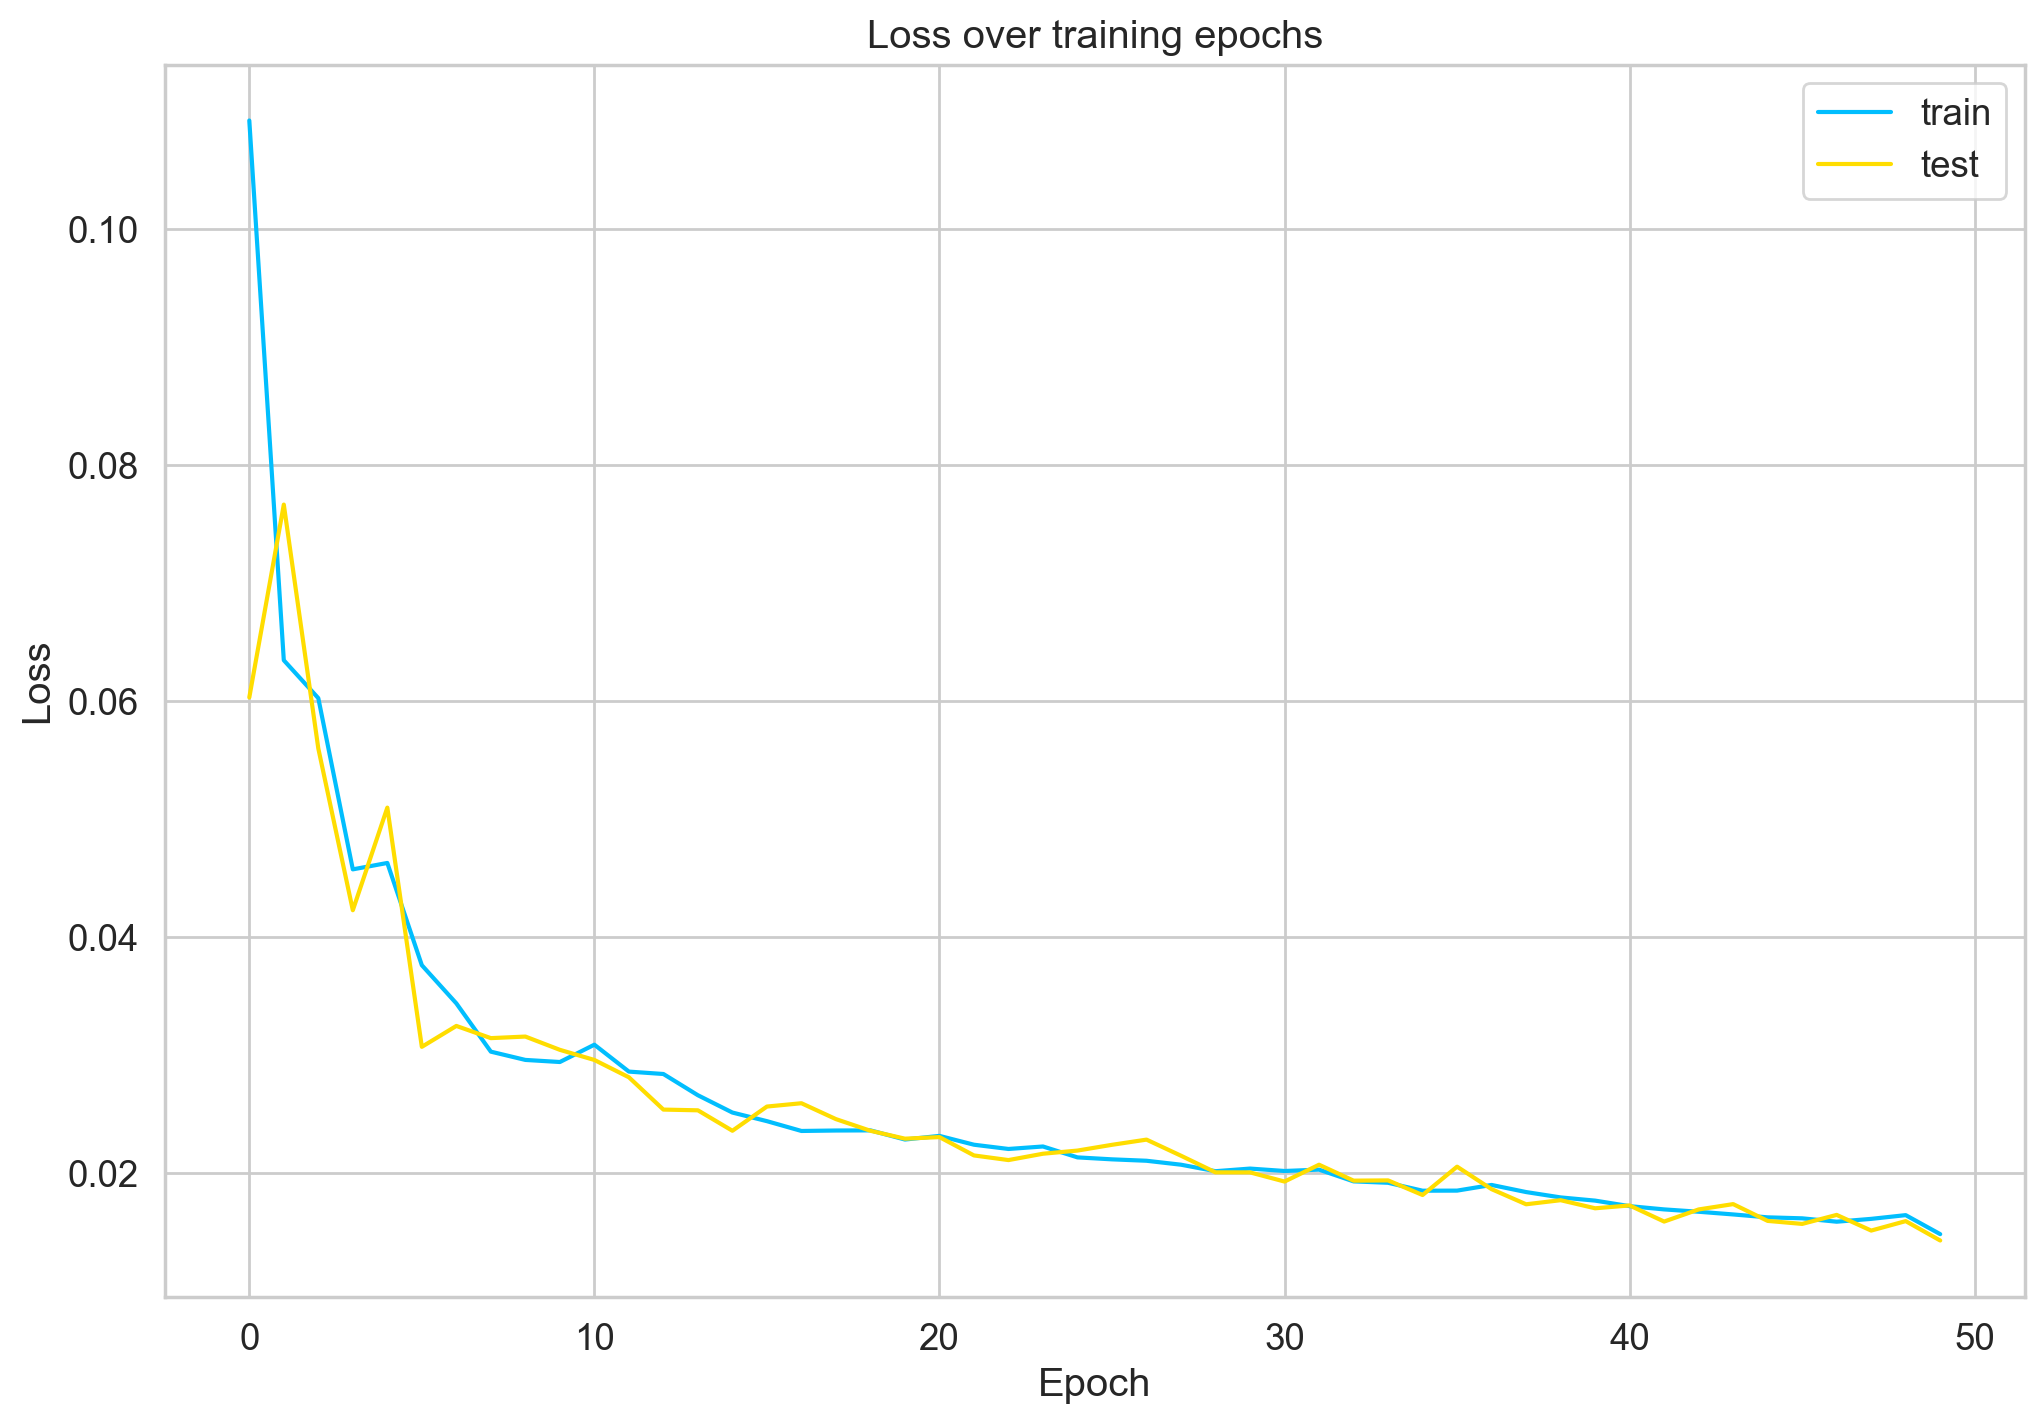

In [32]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

In [33]:
embedding_list = {}
output_list = {}
with torch.no_grad():
    for in_seq,tar_seq,action,vid_size in tqdm(test_dl):
        in_seq = in_seq.to(device)
        tar_seq = tar_seq.to(device)
        seq_pred,embedding  = model(in_seq)

        for seq,emb,action in zip(seq_pred.unbind(0),embedding.unbind(0),action.unbind(0)):
                try:
                    if len(embedding_list[int(action)])<=50:
                        embedding_list[int(action)].append(emb)
                        output_list[int(action)].append(seq)
                except KeyError:
                    embedding_list[int(action)] = [emb]
                    output_list[int(action)] = [emb]

        
            
        
        #embedding_list[]

100%|██████████| 8/8 [00:40<00:00,  5.10s/it]


In [34]:
import random

def draw_heatmaps(arr_list,nrows=2,ncols=2):
    ran_list = random.sample(arr_list,ncols*nrows)
    fig, ax = plt.subplots(nrows=nrows,ncols=ncols, sharex=True)
    for i in range(nrows):
        for j in range(ncols):
            #print(i*ncols+j,len(ran_list))
            ax[i,j].imshow(ran_list[i*ncols+j].detach().cpu().numpy()[np.newaxis,:], cmap="plasma", aspect="auto")

    plt.tight_layout()
    plt.show()

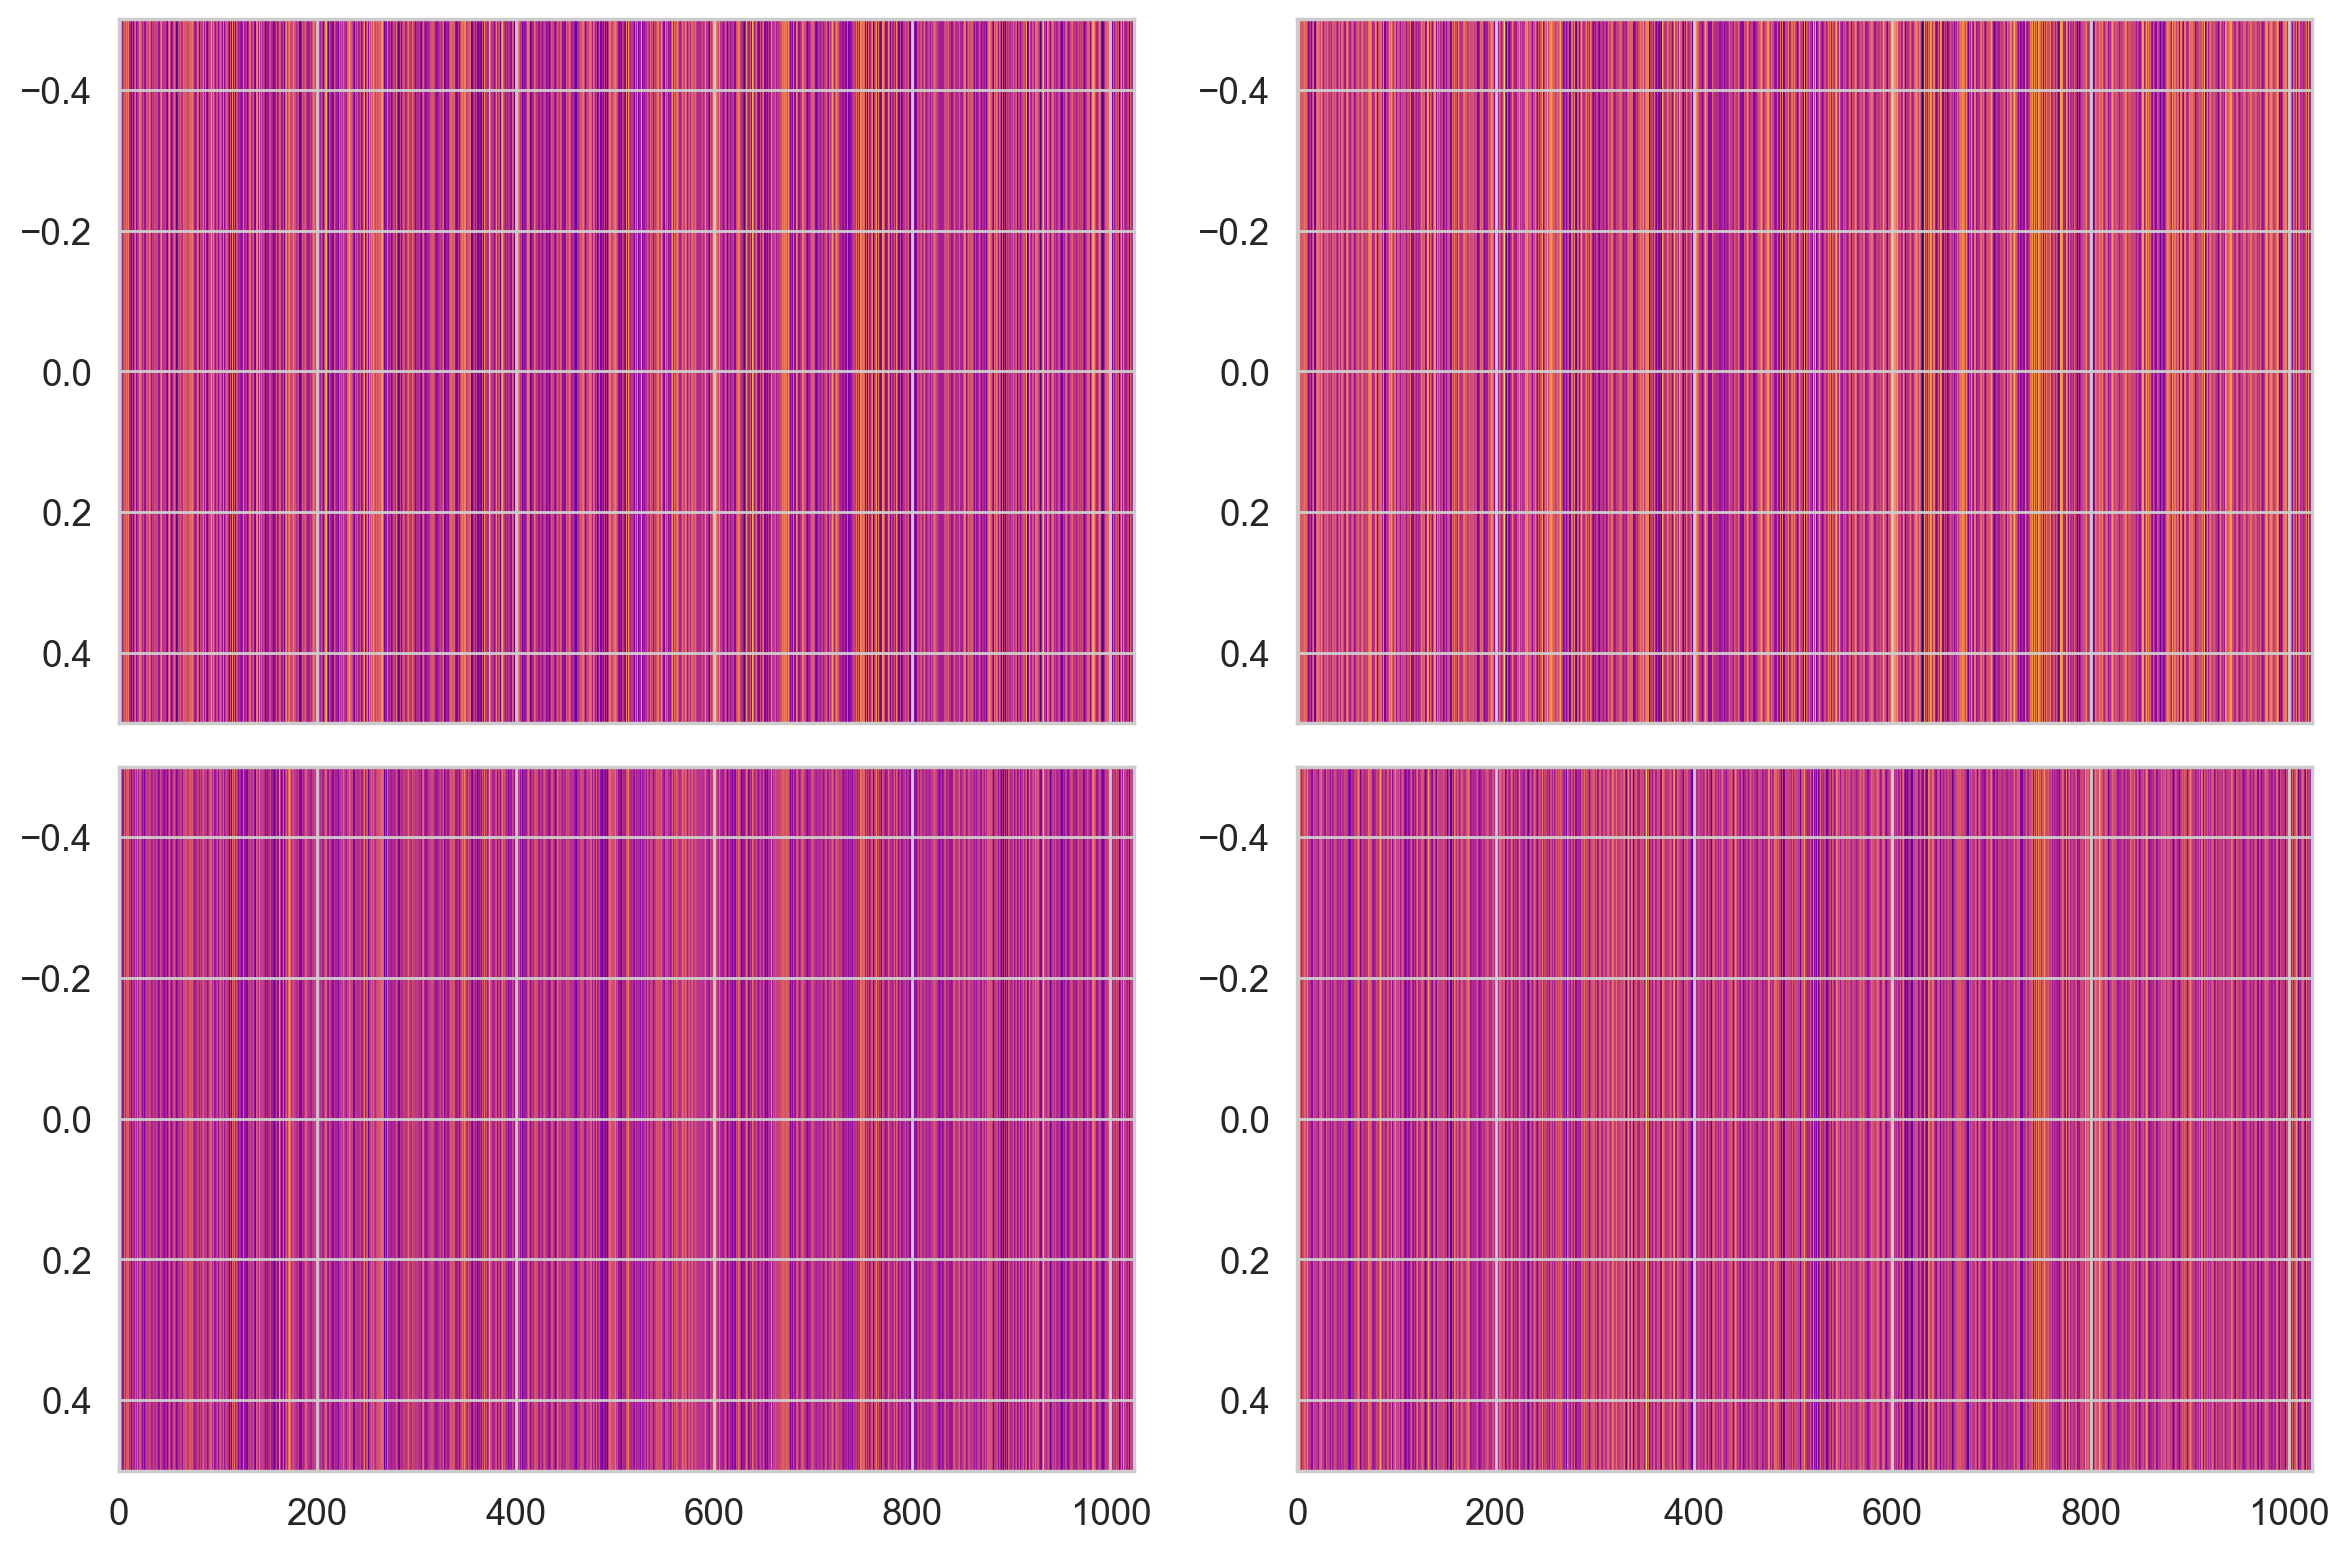

In [35]:
draw_heatmaps(embedding_list[11])

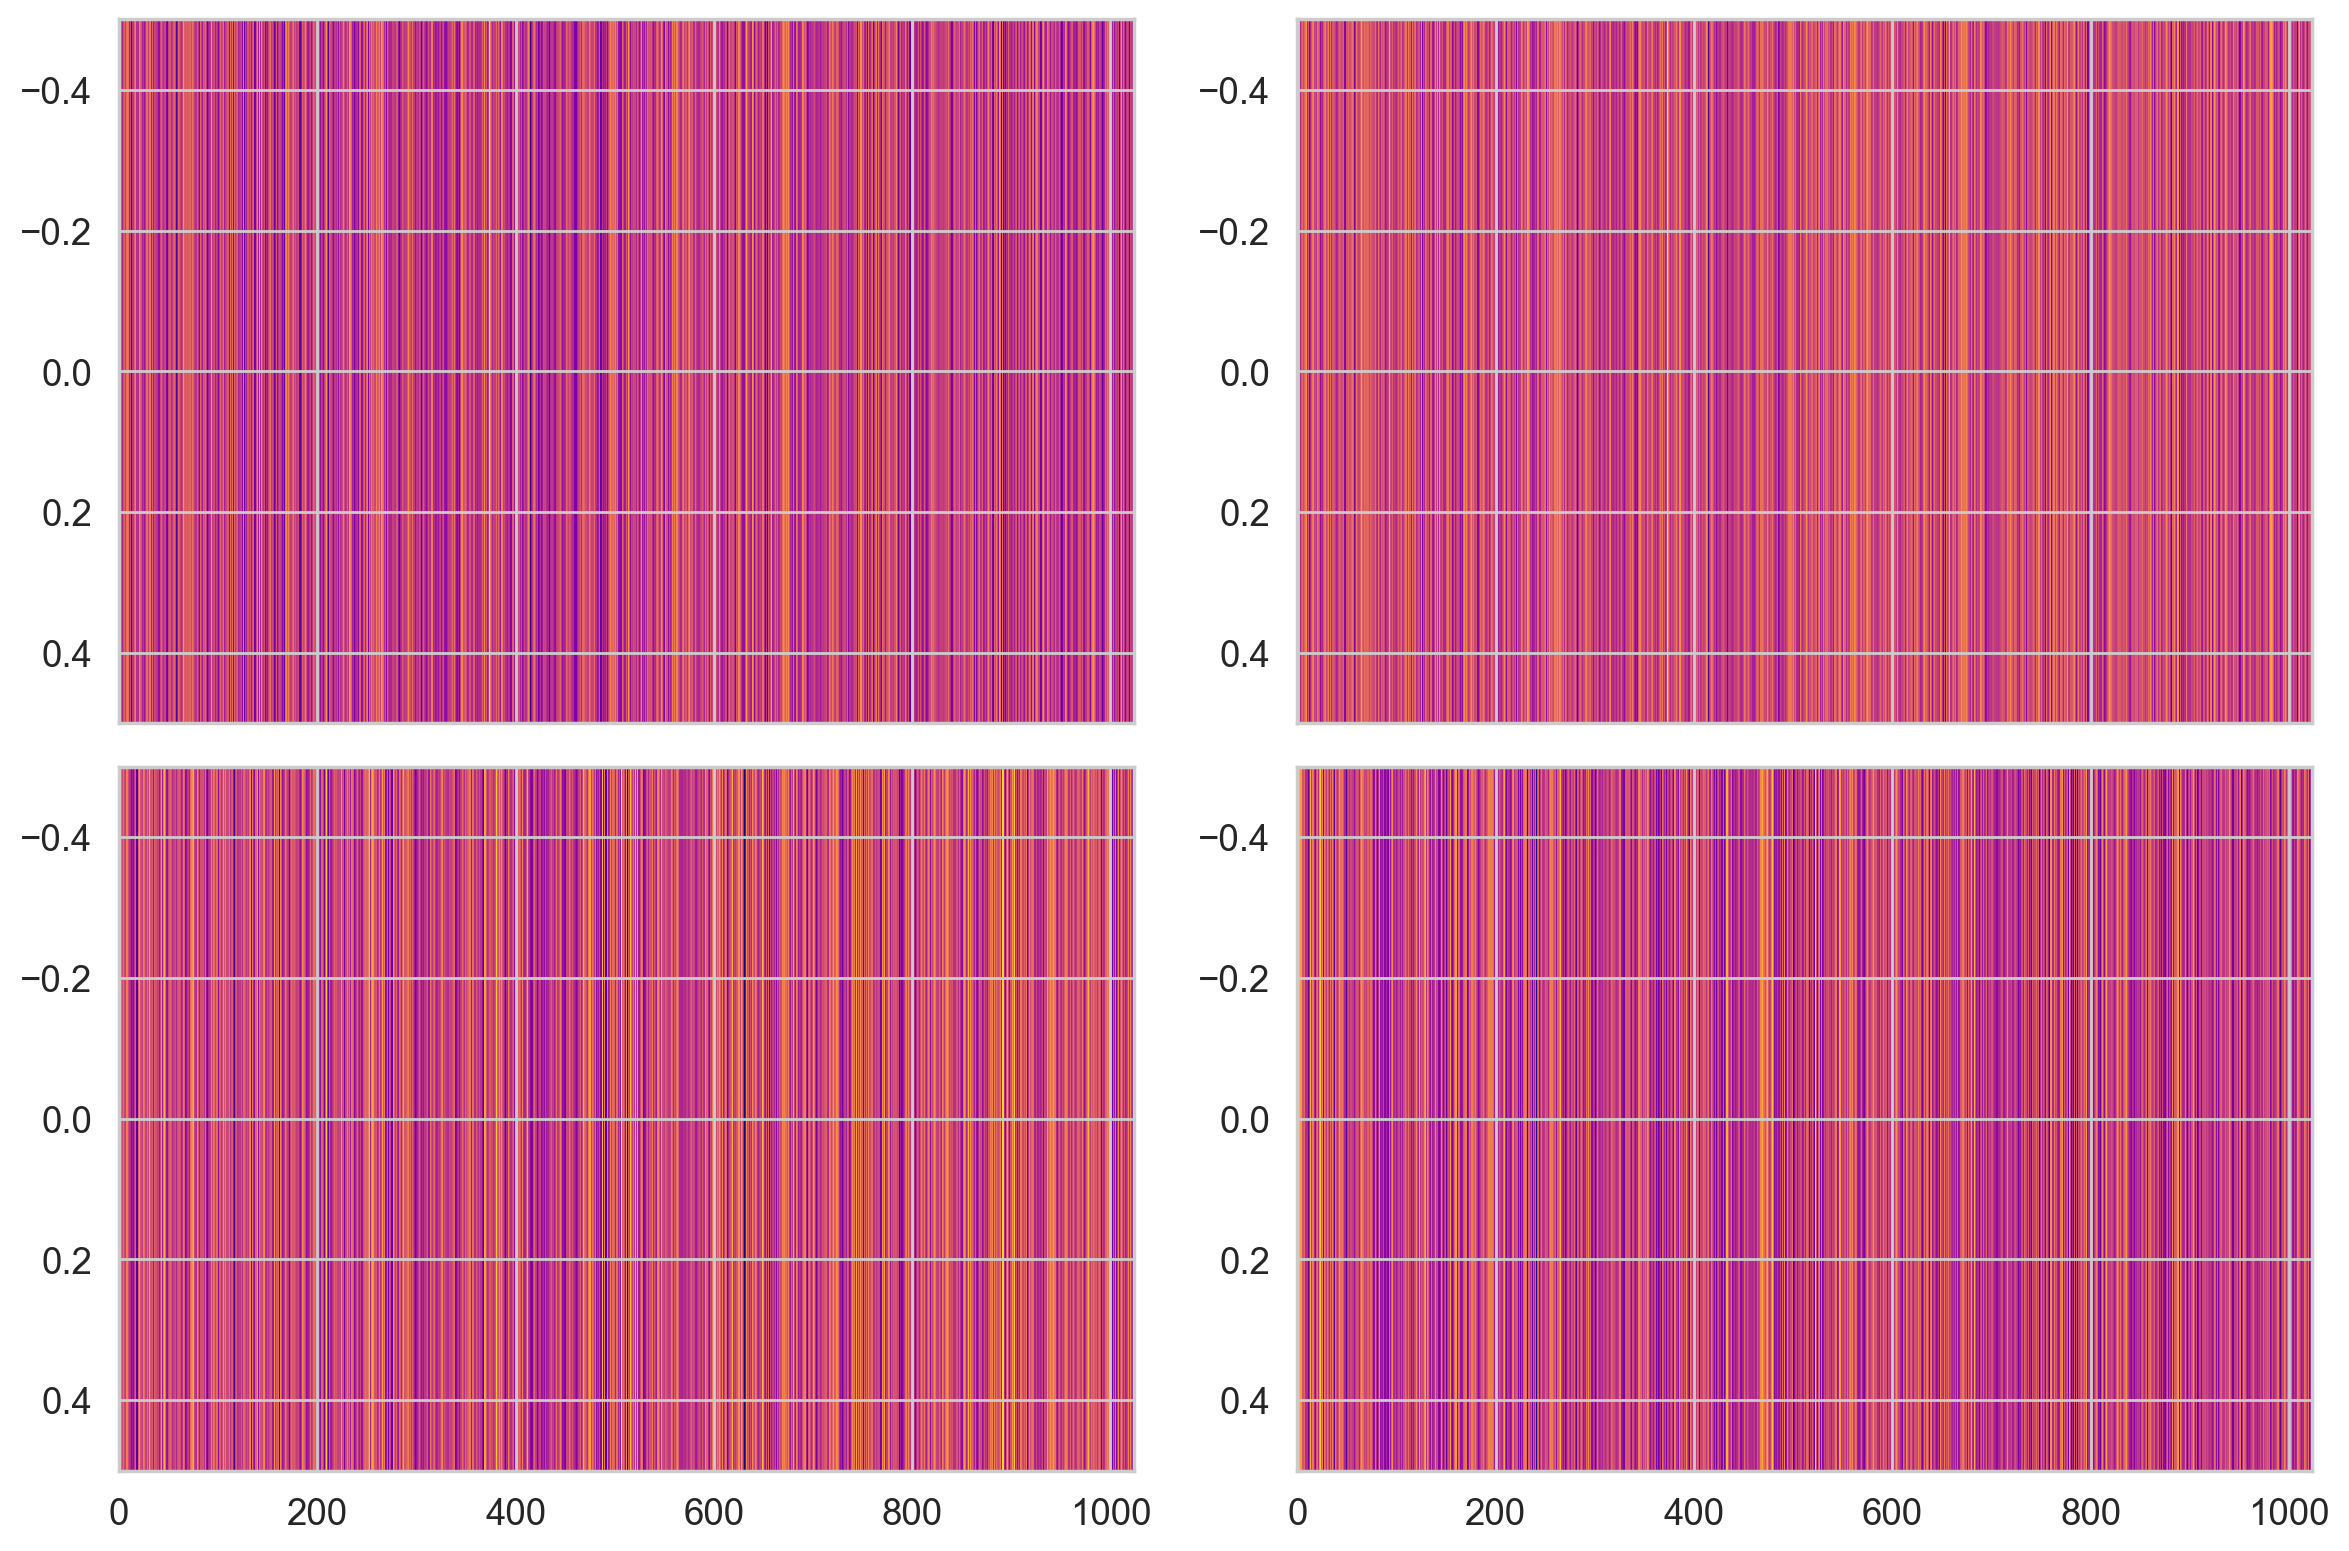

In [36]:
draw_heatmaps(embedding_list[22])

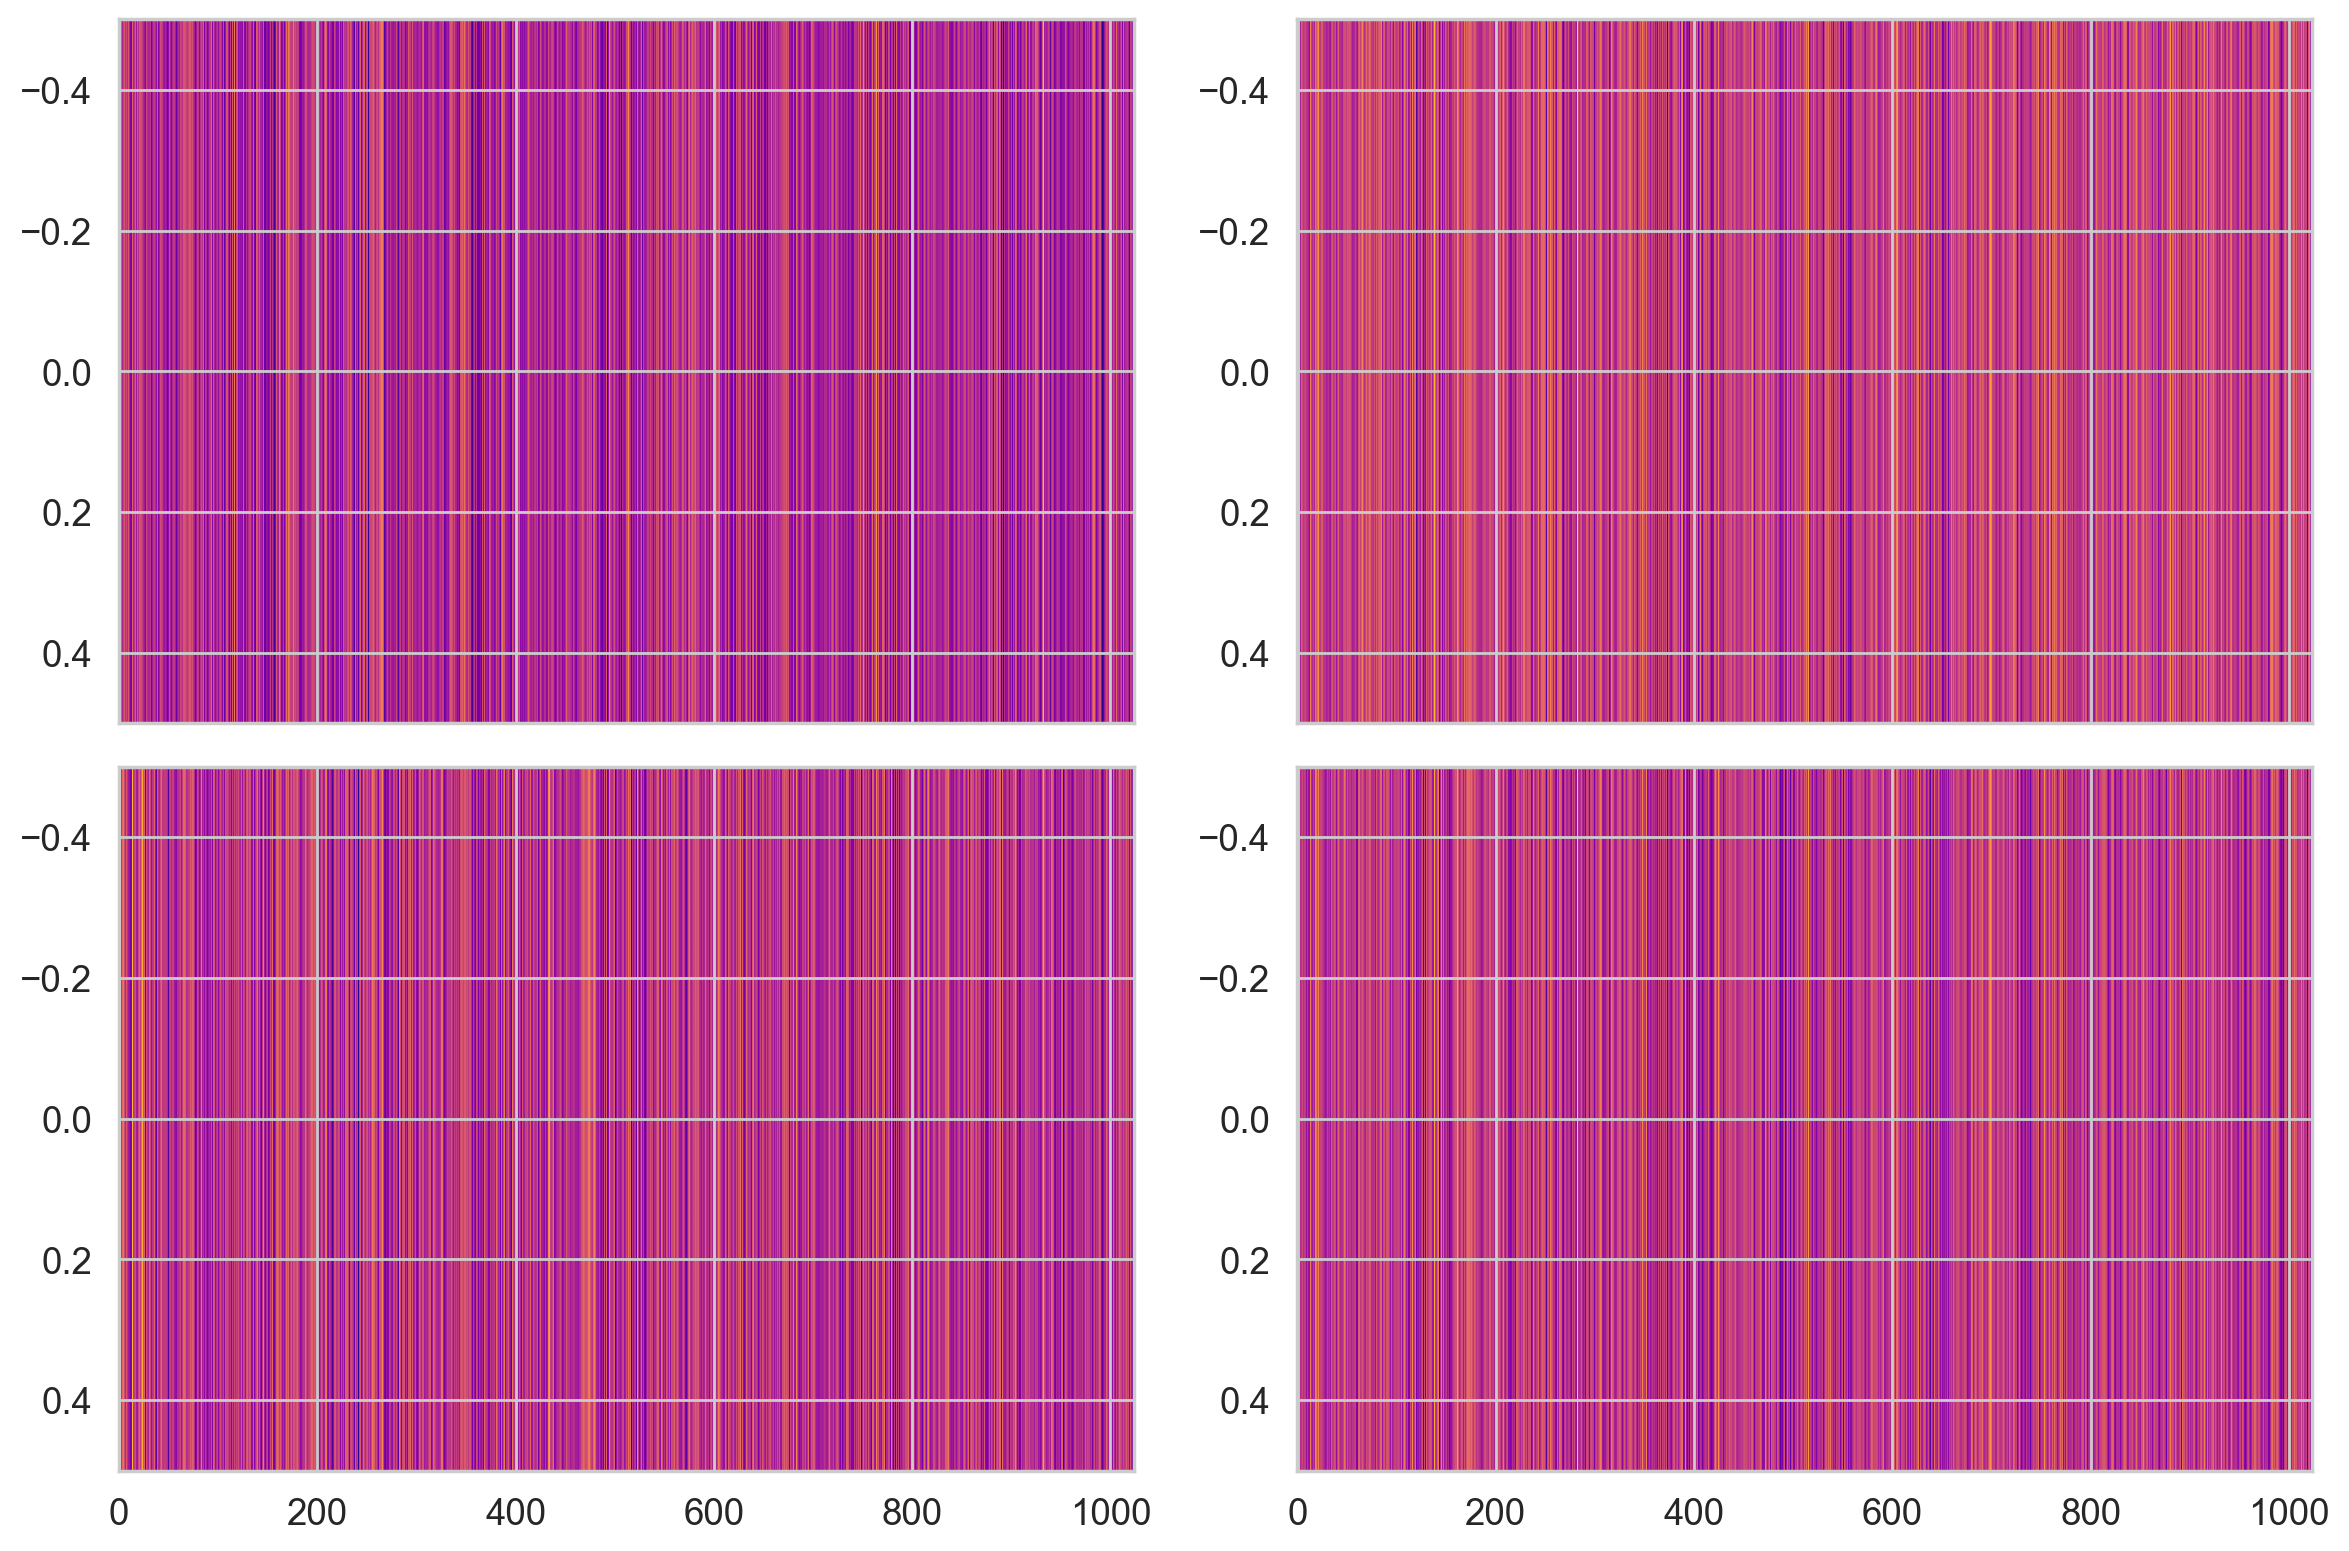

In [37]:
draw_heatmaps(embedding_list[16])

In [38]:
def gen_video_from_embeddings(embedding,model,save_file):
    seq_out = model.decoder(embedding.repeat(batch_size,1,1))
    gen_video(seq_out[0].detach().numpy(), save_file, 400, 400,mapping_list=mapping_l)

In [77]:
with torch.no_grad():
    for __id,(in_seq,tar_seq,action,vid_size) in tqdm(enumerate(test_dl)):
        in_seq = in_seq.to(device)
        tar_seq = tar_seq.to(device)
        seq_pred,embedding  = model(in_seq)

        for __id,(input_vid,output_vid,action) in enumerate(zip(in_seq.unbind(0),seq_pred.unbind(0),action.unbind(0))):
            os.makedirs(f"{test_vids}/{int(action)}",exist_ok=True)

            

        
            
        
        #embedding_list[]

24it [00:12,  1.93it/s]


KeyboardInterrupt: 

In [ ]:
gen_video_from_embeddings(embedding_list[4][10],model,"embed_video.mp4")

In [ ]:
test_emb = 0.5*embedding_list[19][0]+0.5*embedding_list[16][0]
gen_video_from_embeddings(test_emb,model,"test_embed_video.mp4")